# Chemical structure validation and standardization with the RDKit
Greg Landrum greg.landrum@gmail.com <br />
ETH Zürich glandrum@ethz.ch <br />
T5 Informatics GmbH greg.landrum@t5informatics.com

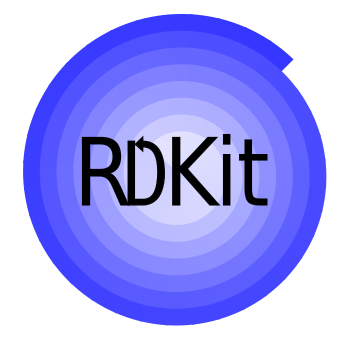




<br />
<br />
<br />
Sample google colab notebook for this presentation: https://bit.ly/3atb9o7

## About me

- Primary developer of the RDKit
- Senior scientist in the Riniker group at the ETH Zürich
- Managing director of T5 Informatics GmbH (provides RDKit-related support and services)
- Senior advisor at KNIME AG

## What we're going to do today

- A quick intro to the RDKit
- Some background on chemical standardization and validation
- Overview of the ChEMBL Structure Pipeline
- Hands-on overview of MolStandardize in the RDKit

<br />
<br />
<br />
Sample google colab notebook for this presentation: https://bit.ly/3atb9o7

## Quick intro to the RDKit

### TL;DR
- `conda install -c conda-forge rdkit`
- https://www.rdkit.org/docs/GettingStartedInPython.html

### Open source toolkit for cheminformatics
- Business-friendly BSD license
- Core data structures and algorithms in C++
- Python 3.x wrappers generated using Boost.Python
- Java and C\# wrappers generated with SWIG
- JavaScript wrapper for use in web applications
- 2D and 3D molecular operations
- Fingerprint/descriptor generation for machine learning
- Molecular database cartridge for PostgreSQL
- Cheminformatics nodes for KNIME (distributed from the KNIME community site: https://www.knime.com/rdkit)

### Operational
- https://www.rdkit.org
- Supports Mac/Windows/Linux
- Feature releases every 6 months, patches about once a month
- Code: https://github.com/rdkit
- Blog(s): https://rdkit.blogspot.com https://greglandrum.github.io/rdkit-blog/
- twitter: [@RDKit_org](http://twitter.com/rdkit_org)

### Support
- Documentation: https://rdkit.org/docs/index.html
- Mailing lists at https://sourceforge.net/p/rdkit/mailman/, searchable archives available for [rdkit-discuss](http://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/) and [rdkit-devel](http://www.mail-archive.com/rdkit-devel@lists.sourceforge.net/)
- GitHub discussions: https://github.com/rdkit/rdkit/discussions
- Commercial support: http://www.t5informatics.com

### The RDKit in the Jupyter notebook

<center>Back to notebook</center>

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
import rdkit
print(rdkit.__version__)

2021.03.1


If a molecule is the result of a cell, it will be displayed:

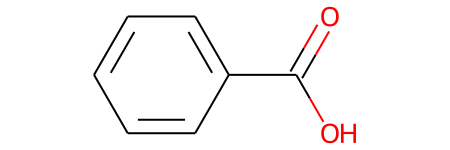

In [2]:
m = Chem.MolFromSmiles('c1ccccc1C(=O)O')
m

You have some control over the way the structures are drawn:

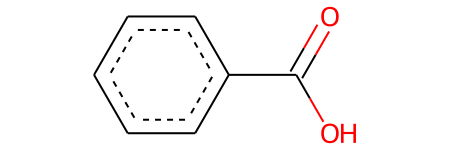

In [3]:
IPythonConsole.kekulizeStructures = False
m

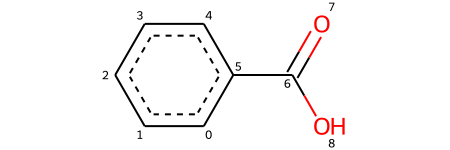

In [4]:
IPythonConsole.drawOptions.addAtomIndices = True
m

In [5]:
IPythonConsole.kekulizeStructures = True
IPythonConsole.drawOptions.addAtomIndices = False


The options available are documented here:
http://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions

If you have py3dmol installed - `conda install -c conda-forge py3dmol` - then you can display 3D structures nicely:

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

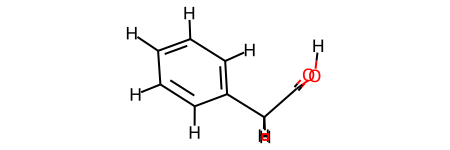

In [14]:
IPythonConsole.ipython_3d = True

from rdkit.Chem import rdDistGeom
m2 = Chem.MolFromSmiles('c1ccccc1CC(=O)O')
mh = Chem.AddHs(m2)
rdDistGeom.EmbedMolecule(mh,randomSeed=0xf00d)
mh

If we don't use that setting, then 3D molecules can be pretty horrible:

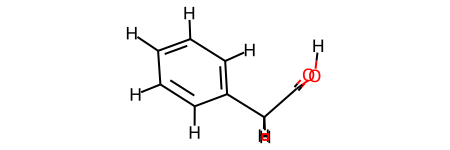

In [7]:
IPythonConsole.ipython_3d = False
mh

We can also display multiple molecules

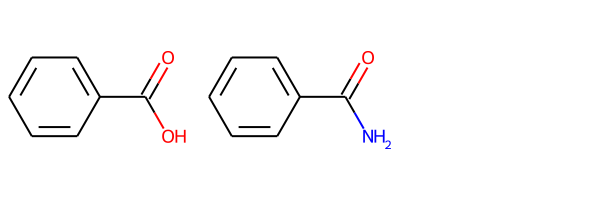

In [8]:
ms = [Chem.MolFromSmiles(x) for x in ('c1ccccc1C(=O)O','c1ccccc1C(=O)N')]
Draw.MolsToGridImage(ms)

And as long as we're in Jupyter, updating the drawing options there changes how `MolsToGridImage()` works

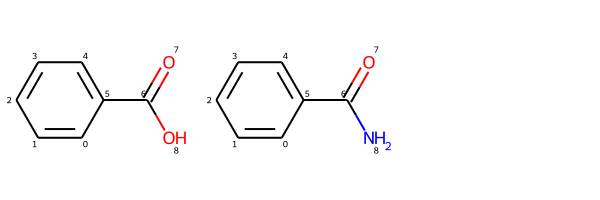

In [9]:
IPythonConsole.drawOptions.addAtomIndices = True
ms = [Chem.MolFromSmiles(x) for x in ('c1ccccc1C(=O)O','c1ccccc1C(=O)N')]
Draw.MolsToGridImage(ms)

In [10]:
IPythonConsole.drawOptions.addAtomIndices = False

[6, 7, 8]


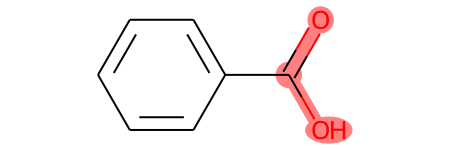

In [16]:
m = Chem.MolFromSmiles('c1ccccc1C(=O)O')
print(list(m.GetSubstructMatch(Chem.MolFromSmiles('C(=O)O'))))
m

Note that, as just pointed out, the behavior of a few functions changes when using the Jupyter notebook.
Here's the list of changes as of the 2021.03 release:
- `Draw.MolsToGridImage()`: uses `IPythonConsole.drawOptions`, so you cannot provide your own drawOptions argument. Returns an Image object so that the results display directly in the notebook.
- `Draw.DrawRDKitBit()`, `Draw.DrawRDKitBits()`, `Draw.DrawMorganBit()`, `Draw.DrawMorganBits()`: return Image objects so that the results display directly in the notebook. 
- `Mol.GetSubstructMatch()` and `Mol.GetSubstructMatches()`: save information about the atoms which matched the substructure so that they can be highlighted. You can disable this behavior by setting `IPythonConsole.highlightSubstructs` to True

If you want to revert these changes and make the notebook act like a standard python environment, you can always do: `IPythonConsole.UninstallIPythonRenderer()`

## Background

### Molecular Validation

- Ensure that a molecule is reasonable/legal for the purpose at hand
- Can be context dependent
- Example checks:
  - Valence rules obeyed
  - Compounds with bad elements removed
  - Compounds with bad substructures removed

### Molecular Standardization
- Apply a set of standard operations to get the molecule ready for whatever you're planning on doing with it
- No one-size-fits-all solution
- Example operations:
  - Functional group normalization, e.g. hypervalent nitro -> charge-separated form
  - Remove redundant chirality specifications
  - Neutralize molecules
  - Remove salts/fragments
  - Tautomer canonicalization


<center>real world example from PubChem Substance</center>

### The RDKit's default validation and standardization

- By default the RDKit performs a set of validation and standardization steps when reading molecules
- This `sanitization` step can be disabled or run independently
- Important: this also does some chemistry perception - aromaticity, implicit valence, hybridization, etc. - which is used in the rest of the code


<center>Back to notebook</center>

#### Validation: Unreasonable valence

In [17]:
Chem.MolFromSmiles('CO(C)C')

RDKit ERROR: [15:48:35] Explicit valence for atom # 1 O, 3, is greater than permitted


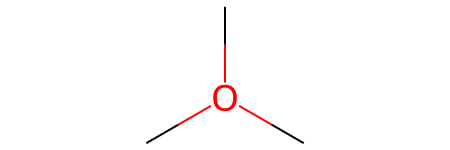

In [18]:
m = Chem.MolFromSmiles('CO(C)C',sanitize=False)
m

#### Validation: bad aromatic systems

In [40]:
Chem.MolFromSmiles('c1cc(C)nn1')

RDKit ERROR: [06:01:01] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
RDKit ERROR: 


RDKit ERROR: [06:02:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
RDKit ERROR: 


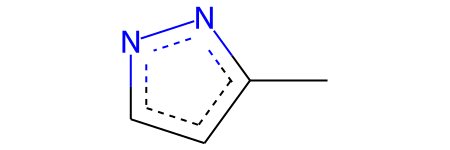

In [46]:
Chem.MolFromSmiles('c1cc(C)nn1',sanitize=False)

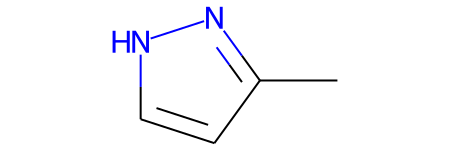

In [47]:
# Note we can fix that by providing the location of the H:
Chem.MolFromSmiles('c1cc(C)n[nH]1')

#### Standardization: cleaning up functional groups

In [12]:
def before_and_after(smis):
    if type(smis)==str:
        smis = [smis]
    ms = []
    for smi in smis:
        m = Chem.MolFromSmiles(smi,sanitize=False)
        m.UpdatePropertyCache(strict=False)
        Chem.SetConjugation(m)
        Chem.SetHybridization(m)
        m1 = Draw.PrepareMolForDrawing(m,kekulize=False)
        m = Chem.MolFromSmiles(smi)
        m2 = Draw.PrepareMolForDrawing(m,kekulize=False)
        ms.extend([m1,m2])
   
    return Draw.MolsToGridImage(ms,legends=['raw','sanitized']*(len(ms)//2),molsPerRow=2)

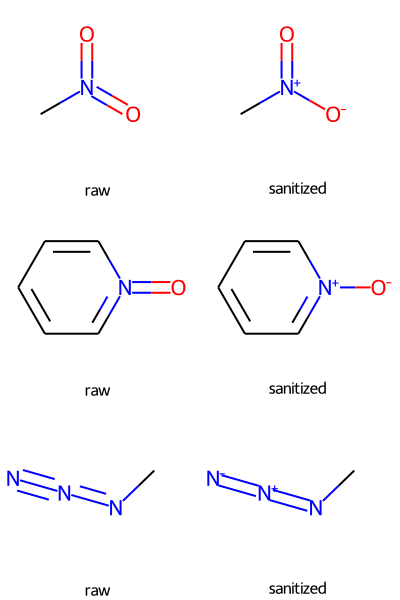

In [14]:
before_and_after(('CN(=O)=O','C1=CC=CN(=O)=C1','C-N=N#N'))

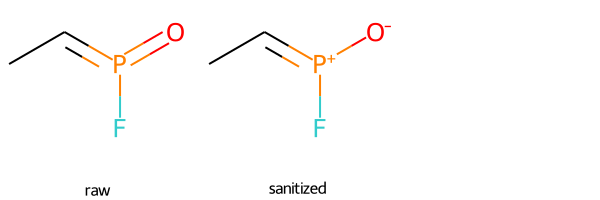

In [9]:
before_and_after('CC=P(=O)F')

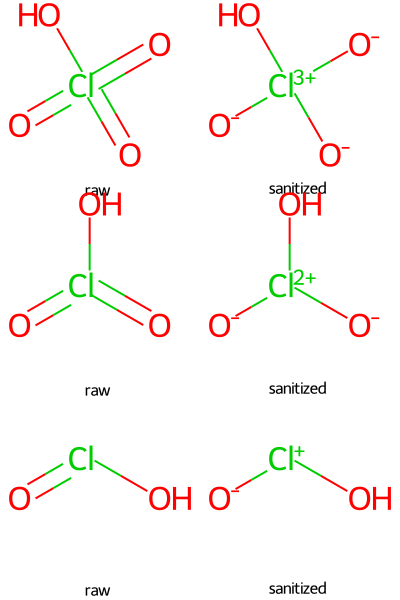

In [15]:
before_and_after(('Cl(=O)(=O)(=O)O','Cl(=O)(=O)O','Cl(=O)O'))

#### Standardization: removing invalid stereochemistry

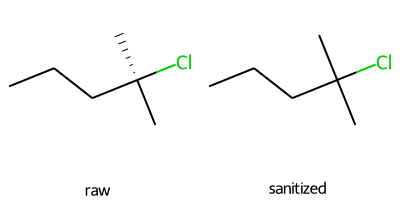

In [25]:
before_and_after('CCC[C@](C)(C)Cl')

In [31]:
# There's no easy way to see that the double bond stereo isn't there:
smi = 'C/C=C(/C)C'
m = Chem.MolFromSmiles(smi,sanitize=False)
m.UpdatePropertyCache()
m.Debug()


RDKit INFO: Atoms:
RDKit INFO: 	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: 0 arom?: 0 chi: 0
RDKit INFO: 	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 0 arom?: 0 chi: 0
RDKit INFO: 	2 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 0 arom?: 0 chi: 0
RDKit INFO: 	3 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: 0 arom?: 0 chi: 0
RDKit INFO: 	4 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: 0 arom?: 0 chi: 0
RDKit INFO: Bonds:
RDKit INFO: 	0 0->1 order: 1 dir: 4 conj?: 0 aromatic?: 0
RDKit INFO: 	1 1->2 order: 2 conj?: 0 aromatic?: 0
RDKit INFO: 	2 2->3 order: 1 dir: 4 conj?: 0 aromatic?: 0
RDKit INFO: 	3 2->4 order: 1 conj?: 0 aromatic?: 0


In [32]:
m = Chem.MolFromSmiles(smi)
m.Debug()


RDKit INFO: Atoms:
RDKit INFO: 	0 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: 4 arom?: 0 chi: 0
RDKit INFO: 	1 6 C chg: 0  deg: 2 exp: 3 imp: 1 hyb: 3 arom?: 0 chi: 0
RDKit INFO: 	2 6 C chg: 0  deg: 3 exp: 4 imp: 0 hyb: 3 arom?: 0 chi: 0
RDKit INFO: 	3 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: 4 arom?: 0 chi: 0
RDKit INFO: 	4 6 C chg: 0  deg: 1 exp: 1 imp: 3 hyb: 4 arom?: 0 chi: 0
RDKit INFO: Bonds:
RDKit INFO: 	0 0->1 order: 1 conj?: 0 aromatic?: 0
RDKit INFO: 	1 1->2 order: 2 conj?: 0 aromatic?: 0
RDKit INFO: 	2 2->3 order: 1 conj?: 0 aromatic?: 0
RDKit INFO: 	3 2->4 order: 1 conj?: 0 aromatic?: 0


## Overview of the ChEMBL Structure Pipeline

Implements the validation and standardization rules used for loading compounds into ChEMBL

https://github.com/chembl/ChEMBL_Structure_Pipeline

https://doi.org/10.1186/s13321-020-00456-1

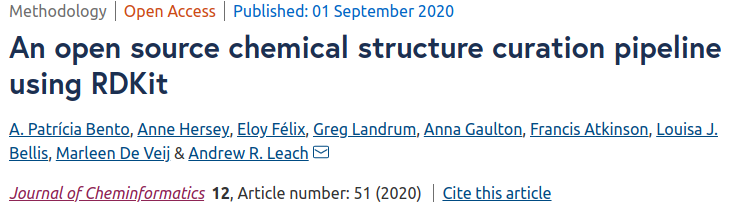


### Components of the ChEMBL Structure Pipeline
- Checker: tests validity and flags errors
- Standardizer: applies ChEMBL standardization rules
- GetParent: removes salts and solvents 

Extensive detail about the components and what they do available on the wiki: https://github.com/chembl/ChEMBL_Structure_Pipeline/wiki

<center>real world example from PubChem Substance</center>

## Some other RDKit-related possibilities:

- Standardiser (https://github.com/flatkinson/standardiser): from Francis Atkinson. Doesn't seem actively maintained
- Avalon toolkit STRUCHK (https://sourceforge.net/p/avalontoolkit/wiki/Home/): from Bernd Rohde. Useable directly in the RDKit via `rdkit.AvalonTools.pyAvalonTools`. Quite powerful and flexible, doesn't seem actively maintained
- RDKit reimplementation of STRUCHK: no longer maintained, not built by default
- MolVS (https://molvs.readthedocs.io/en/latest/): from Matt Swain. Inspiration for the RDKit's MolStandardize

## MolStandardize in the RDKit

- Started as a port of Matt Swain's MolVS (https://molvs.readthedocs.io/en/latest/) to C++
  - 2018 Google Summer of Code Project by Susan Leung
- Extended and expanded since the original project
- Part of the RDKit core


### Operations available in MolStandardize (RDKit v2021.03)
- Normalize: apply standard transformations
- Neutralize: make the overall molecule neutral (when possible)
- Reionize: rearrange charges to (hopefully) more stable form
- Tautomers: enumerate, score, pick canonical tautomer
- Disconnect metal atoms: break most bonds from metals
- Strip fragments: remove salts, metals, solvents
- Validation: allowed atoms and disallowed atoms validation

<center>examples</center>

## Thanks!

Questions?


- GitHub discussions: https://github.com/rdkit/rdkit/discussions

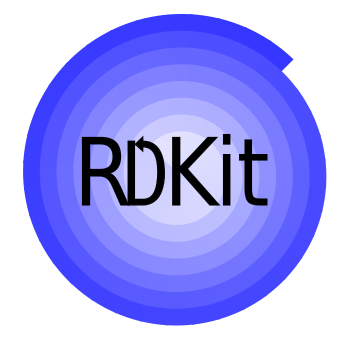

- Commercial support: greg.landrum@t5informatics.com http://t5informatics.com 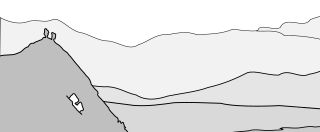 
